In [9]:
import itertools
from rosemary import jpt_in_notebook
from llm.submit import submit_job, multiline_to_singleline

shell_scripts_template = """
echo "Running on $SLURM_JOB_NODELIST"
echo "======"

master_addr=$(scontrol show hostnames "$SLURM_JOB_NODELIST" | head -n 1)
master_port=10002
RDZV_ENDPOINT=$master_addr:$master_port

source ~/.profile
conda activate open-instruct
cd /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts

set -e
set -x
echo "======"
srun {cmd}

[ ! -f "{log_dir}/$SLURM_JOB_ID*.out" ] && mv {log_dir}/$SLURM_JOB_ID*.out {save_dir}
"""

test_run = 1
test_run = bool(test_run)

model_name = 'llama-7b'
model_name = 'llama-7b_tulu_v1_human_mix' # means llama-7b finetuned on tulu humanmix already.

save_dir = f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/{model_name}/"
lm_output_dir = f'/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/{model_name}'
log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

    
dataset_list = [
    'flan_v2', 
#     'tulu_v1_human_mix',
] 
sort_by_list = [
    'random', 'prob',
    'kmeansl2_nc=300', 'kmeansl2_nc=1000', 'kmeansl2_nc=3000',
    'dppmap_k=Kcos', 'dppmap_k=Kcosp', 'dppmap_k=Kcos1np', 
]

options_list = itertools.product(dataset_list, sort_by_list)

cmds = []
for dataset, sort_by in options_list:
    cmd = f"""
     python note_pruning.py \
        --dataset {dataset} \
        --sort_by {sort_by} \
        --lm_output_dir {lm_output_dir} \
        --save_dir {save_dir} \
    """.strip()
    cmd = multiline_to_singleline(cmd)
    shell_scripts = shell_scripts_template.format(
        cmd=cmd, log_dir=log_dir, save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=f'prune.{dataset}.{sort_by}', 
        nodes=1,
        num_cpus=32,
        cpu_mem=128,
        num_gpus=1,
        gpu_type='v100',
        test_run=test_run,
        job_duration=6,
    )
    cmds.append(cmd)
    if not test_run:
        print(cmd)
        
print('#cmds: ', len(cmds))



Submiting job with:
{
    "job_name": "prune.tulu_v1_human_mix.prob",
    "nodes": 1,
    "num_cpus": 32,
    "cpu_mem": 128,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
python note_pruning.py --dataset tulu_v1_human_mix --sort_by prob --lm_output_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/llama-7b_tulu_v1_human_mix --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b_tulu_v1_human_mix/

Submiting job with:
{
    "job_name": "prune.tulu_v1_human_mix.kmeansl2_nc=300",
    "nodes": 1,
    "num_cpus": 32,
    "cpu_mem": 128,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
python note_pruning.py --dataset tulu_v1_human_mix --sort_by kmeansl2_nc=300 --lm_output_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_

In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5'
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


In [2]:
import os
import sys
import numpy as np
import time
import re
import random
import pickle
from tqdm import tqdm 

import pyarrow
import torch
import transformers

from note_pruning import (
    save_to_pickle,
    save_sorted_inds,
    sort_kmeans_l2_to_prototypes,
    sort_dpp_map,)

In [9]:
test_run = False
dataset = 'tulu_v1_human_mix'
dataset = 'tulu_v2_human_mix'
dataset = 'flan_v2'
dataset = 'lima'

# sort_by = 'random'
# sort_by = 'kmeansl2_nc=100'
# sort_by = 'prob'
# sort_by = 'dppmap_k=Kcos'
# sort_by = 'dppmap_k=Kcos1np'
sort_by = 'el2n'

# used for generating model output.
model_name = 'llama-7b'
# model_name = 'llama-7b_ft=hmv1'


save_dir = f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/{model_name}/"
lm_output_dir = f'/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/{model_name}'
save_dir = os.path.join(save_dir, dataset)
os.makedirs(save_dir, exist_ok=True)

In [19]:

save_path = os.path.join(lm_output_dir, f'{dataset}.pkl')
with open(save_path, 'rb') as f:
    d = pickle.load(f)
if test_run:
    d = {k: v[:1000] for k, v in d.items()}

# some entries are nan, impute with mean value.
text_embeddings = d['text_embeddings']
log_probs = np.nan_to_num(d['log_probs'], nan=np.nanmean(d['log_probs'])).squeeze()
el2ns = np.nan_to_num(d['el2ns'], nan=np.nanmean(d['el2ns'])).squeeze()

(1030,)

In [18]:



if sort_by.startswith('random'):
    random.seed(0)
    inds = list(range(log_probs.shape[0]))
    random.shuffle(inds)
elif sort_by == 'prob':
    S = log_probs
elif sort_by == 'el2n':
    S = el2ns
if sort_by.startswith('kmeansl2'):
    match = re.search(r'(?<=\=)\d+', sort_by)
    n_clusters = int(match.group()) if match else None
    S = sort_kmeans_l2_to_prototypes(text_embeddings, n_clusters)
elif sort_by.startswith('dpp'):
    match = re.search(r'k=(\w+)', sort_by)
    kernel_type = match.group(1) if match else None  
    inds = sort_dpp_map(text_embeddings, log_probs, kernel_type=kernel_type)

if any(sort_by.startswith(x) for x in ['dpp', 'random']):
    save_to_pickle(
        save_path=os.path.join(save_dir, f'{sort_by}.pkl'),
        output={'inds': inds})
else:
    save_sorted_inds(save_dir, S, sort_by, reverse=False)
    save_sorted_inds(save_dir, S, sort_by, reverse=True)



save inds (length = 1030) to /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b/lima/el2n_incr.pkl
save inds (length = 1030) to /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b/lima/el2n_decr.pkl


[777,
 385,
 638,
 310,
 270,
 770,
 4,
 147,
 661,
 1020,
 152,
 217,
 612,
 658,
 364,
 88,
 730,
 109,
 164,
 320,
 214,
 497,
 950,
 301,
 417,
 990,
 54,
 908,
 269,
 25,
 726,
 283,
 843,
 255,
 782,
 339,
 402,
 1003,
 517,
 783,
 598,
 764,
 181,
 279,
 175,
 390,
 1023,
 636,
 467,
 954,
 137,
 284,
 513,
 733,
 677,
 236,
 880,
 125,
 522,
 261,
 568,
 776,
 98,
 767,
 909,
 263,
 713,
 599,
 810,
 630,
 563,
 738,
 964,
 919,
 92,
 647,
 739,
 144,
 6,
 219,
 160,
 211,
 588,
 1022,
 416,
 644,
 305,
 942,
 302,
 61,
 205,
 687,
 60,
 846,
 45,
 586,
 554,
 768,
 502,
 704,
 399,
 363,
 48,
 763,
 570,
 686,
 771,
 521,
 779,
 128,
 1026,
 371,
 816,
 35,
 243,
 374,
 1016,
 389,
 551,
 81,
 304,
 992,
 68,
 460,
 882,
 275,
 473,
 34,
 1012,
 426,
 331,
 465,
 353,
 904,
 326,
 391,
 832,
 78,
 916,
 496,
 789,
 694,
 383,
 881,
 523,
 936,
 26,
 552,
 280,
 451,
 962,
 833,
 368,
 933,
 979,
 69,
 528,
 278,
 798,
 785,
 168,
 772,
 728,
 421,
 982,
 231,
 873,
 201,
 139,

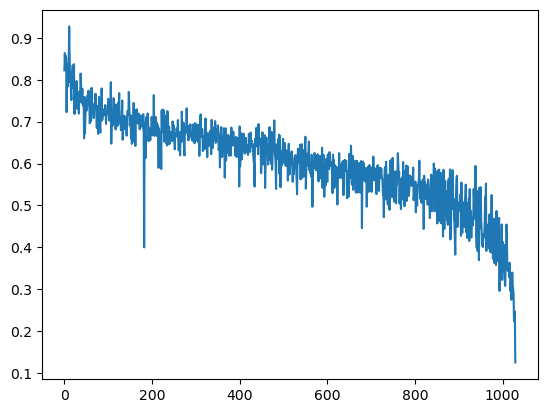

In [29]:
inds = np.argsort(log_probs)

# inds = np.argsort(S)

plt.plot(el2ns[inds])



In [49]:
inds[:3]

[75931, 11173, 208719]

In [70]:
dataset, inds[:3]

('flan_v2', [74921, 6849, 99252])